In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\ADMIN\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
pip install torch_geometric

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\ADMIN\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
%%capture
!kaggle datasets download -d vitvhong/uplink
!unzip uplink.zip -d ./uplink
%cd uplink

In [3]:
import numpy as np
import torch
from torch_geometric.loader import  DataLoader
from torch_geometric.data import HeteroData, Data, Dataset, Batch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
import torch.nn as nn
from torch.nn import Sequential as Seq, Linear as Lin, ReLU, ELU, Sigmoid, BatchNorm1d as BN, ReLU6 as ReLU6
import scipy.io
from torch_geometric.nn import HeteroConv, SAGEConv
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
import matplotlib.pyplot as plt

In [4]:
train_layouts = 10000
test_layouts = 200

In [5]:
data = scipy.io.loadmat('cf_train_6_30.mat')
beta_train = data['betas'][:train_layouts]
direct_train = data['directs'][:train_layouts]
cross_train = data['corsses'][:train_layouts].transpose(0,2,1)

In [6]:
test_data = scipy.io.loadmat('cf_test_6_30.mat')
beta_test = test_data['betas']
direct_test = test_data['directs']
cross_test = test_data['corsses'].transpose(0,2,1)

In [7]:
def normalize_data(train_data,test_data):
    train_mean = np.mean(train_data)
    train_std = np.std(train_data)
    norm_train = (train_data)/train_std
    norm_test = (test_data)/train_std
    n1, n2 = norm_train.shape[0], norm_test.shape[0]
    return norm_train, norm_test
norm_train_losses, norm_test_losses = normalize_data(beta_train**(1/2), beta_test**(1/2) )

In [8]:
## For GNNs, we allow train_K \neq test_K
train_K, train_M = beta_train.shape[2], beta_train.shape[1]
test_K, test_M = beta_test.shape[2], beta_test.shape[1]

In [9]:
class PCDataset(Dataset):
    def __init__(self, norm_losses, direct, cross, KM):
        self.norm_losses = norm_losses
        self.direct = torch.tensor(direct, dtype=torch.float)
        self.cross = torch.tensor(cross, dtype=torch.float)
        self.KM = KM
        self.get_cg()
        self.process()

    def build_graph(self, idx):
        edge_feature = self.norm_losses[idx, :, :].reshape((self.KM[0] * self.KM[1], 1), order='F')
        edge_feature = np.concatenate((edge_feature, np.ones_like(edge_feature)), axis=-1)
        edge_feature = torch.tensor(edge_feature, dtype=torch.float)

        edge_index = torch.tensor(self.adj, dtype=torch.long).t().contiguous()
        edge_index_t = torch.tensor(self.adj_t, dtype=torch.long).t().contiguous()
        ue_features = torch.ones((self.KM[0], 1))
        ap_features = torch.ones((self.KM[1], 1))

        data = HeteroData()
        data['UE'].x = ue_features
        data['AP'].x = ap_features
        data['UE', 'com-by', 'AP'].edge_index = edge_index
        data['UE', 'com-by', 'AP'].edge_attr = edge_feature
        data['AP', 'com', 'UE'].edge_index = edge_index_t
        data['AP', 'com', 'UE'].edge_attr = edge_feature

        return data

    def get_cg(self):
        self.adj = []
        self.adj_t = []
        for i in range(self.KM[0]):
            for j in range(self.KM[1]):
                self.adj.append([i, j])
                self.adj_t.append([j, i])

    def process(self):
        self.graph_list = [self.build_graph(i) for i in range(len(self.direct))]

    def __len__(self):
        return len(self.direct)

    def __getitem__(self, index):
        return self.graph_list[index], self.direct[index], self.cross[index]

In [10]:
def collate(samples):
    '''Pytorch Geometric collate function'''
    graphs, direct, cross = map(list, zip(*samples))
    batched_graph = Batch.from_data_list(graphs)
    return batched_graph, torch.stack(direct), torch.stack(cross)

In [11]:
train_data = PCDataset(norm_train_losses, direct_train, cross_train, (train_K, train_M))
test_data = PCDataset(norm_test_losses, direct_test, cross_test, (test_K, test_M))

# Mục mới

In [12]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size, shuffle=True, collate_fn=collate)
test_loader = DataLoader(test_data, test_layouts, shuffle=False, collate_fn=collate)

In [13]:
def rate_loss(allocs, directlink_channel_losses, crosslink_channel_losses, test_mode = False):
    SINRs_numerators = allocs * directlink_channel_losses**2
    SINRs_denominators = torch.squeeze(torch.matmul(crosslink_channel_losses, torch.unsqueeze(allocs, axis=-1))) + directlink_channel_losses
    SINRs = SINRs_numerators / SINRs_denominators
    rates = torch.log2(1 + SINRs)
    min_rate = torch.min(rates, dim = 1)[0] # take min
    if test_mode:
        return min_rate
    else:
        return -torch.mean(min_rate)

In [14]:
def MLP(channels, batch_norm=True):
    return Seq(*[
        Seq(Lin(channels[i - 1], channels[i]), ReLU(), BN(channels[i]))
        for i in range(1, len(channels))
    ])
class EdgeConv(MessagePassing):
    def __init__(self, input_dim, node_dim, dim_out, **kwargs):
        super(EdgeConv, self).__init__(aggr='mean')  # mean aggregation
        self.lin = MLP([input_dim, dim_out])
        self.res_lin = Lin(node_dim, dim_out)
        self.bn = BN(dim_out)

    def forward(self, x, edge_index, edge_attr):

        feat_src, feat_dst = x


        out = self.propagate(edge_index=edge_index, x=(feat_src, feat_dst), edge_attr=edge_attr)


        return self.bn(out + self.res_lin(feat_dst))

    def message(self, x_j, x_i, edge_attr):
        # Tạo ra thông điệp từ các nút nguồn, nút đích và đặc tính cạnh
        out = torch.cat([x_j, x_i, edge_attr], dim=1)
        return self.lin(out)

    def update(self, aggr_out):
        # Cập nhật giá trị nút đích sau khi tập hợp
        return aggr_out



In [15]:
class RGCN(nn.Module):
    def __init__(self):
        super(RGCN, self).__init__()
        self.conv1 = HeteroConv({
            ('UE', 'com-by', 'AP'): EdgeConv(4, 1, 32),
            ('AP', 'com', 'UE'): EdgeConv(4, 1, 32)
        }, aggr='mean')

        self.conv2 = HeteroConv({
            ('UE', 'com-by', 'AP'): EdgeConv(66, 32, 32),
            ('AP', 'com', 'UE'): EdgeConv(66, 32, 32)
        }, aggr='mean')

        self.conv3 = HeteroConv({
            ('UE', 'com-by', 'AP'): EdgeConv(66, 32, 32),
            ('AP', 'com', 'UE'): EdgeConv(66, 32, 32)
        }, aggr='mean')

        self.mlp = MLP([32, 16])
        self.mlp = nn.Sequential(*[self.mlp, Seq(Lin(16, 1), Sigmoid())])

    def forward(self,x_dict, edge_index_dict, edge_attr_dict):
        out = self.conv1(x_dict, edge_index_dict, edge_attr_dict)
        out = self.conv2(out, edge_index_dict, edge_attr_dict)
        out = self.conv3(out, edge_index_dict, edge_attr_dict)
        out = self.mlp(out['UE'])
        return out


In [28]:
model = RGCN()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

In [17]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 14593


In [17]:
def train_model(epoch, model, optimizer, train_loader):
    """ Train for one epoch. """
    model.train()
    loss_all = 0
    for batch_idx, (data, d_train, c_train) in enumerate(train_loader):
        K = d_train.shape[-1]
        n = len(data['UE'].x)
        bs = len(data['UE'].x) // K

        optimizer.zero_grad()

        # Lấy các đặc trưng nút từ từ điển x_dict
        user_feats = data['AP'].x
        item_feats = data['UE'].x
        node_features = {'AP': user_feats, 'UE': item_feats}

        # Truyền qua mô hình, bao gồm cả edge_attr_dict
        output = model(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)

        # Tính loss và thực hiện backpropagation
        loss = rate_loss(output, d_train, c_train)
        loss.backward()

        loss_all += loss.item() * bs
        optimizer.step()

    return loss_all / len(train_loader.dataset)

def test_model(loader, model):
    model.eval()
    correct = 0
    with torch.no_grad():
        for (data, d_test, c_test) in loader:
            K = d_test.shape[-1]
            n = len(data['UE'].x)
            bs = len(data['UE'].x) // K

            # Lấy các đặc trưng nút từ từ điển x_dict
            user_feats = data['AP'].x
            item_feats = data['UE'].x
            # Create a dictionary for node features
            node_features = {'AP': user_feats, 'UE': item_feats}

            output = model(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)

            # Tính loss
            loss = rate_loss(output, d_test, c_test)
            correct += loss.item() * bs

    return correct / len(loader.dataset)

In [29]:
record = []

for epoch in range(0, 100):
    if epoch % 1 == 0:
        with torch.no_grad():
            test_rate = test_model(test_loader, model)
            train_rate = test_model(train_loader, model)
        print(f'Epoch {epoch:03d}, Train Rate: {train_rate:.4f}, Test Rate: {test_rate:.4f}')
        record.append([train_rate, test_rate])

    train_model(epoch, model, optimizer, train_loader )
    scheduler.step()


Epoch 000, Train Rate: -0.5391, Test Rate: -0.5390
Epoch 001, Train Rate: -0.7966, Test Rate: -0.7903
Epoch 002, Train Rate: -0.8632, Test Rate: -0.8530
Epoch 003, Train Rate: -0.9017, Test Rate: -0.8857
Epoch 004, Train Rate: -0.9070, Test Rate: -0.8951
Epoch 005, Train Rate: -0.9470, Test Rate: -0.9324
Epoch 006, Train Rate: -0.9646, Test Rate: -0.9523
Epoch 007, Train Rate: -0.9656, Test Rate: -0.9496
Epoch 008, Train Rate: -1.0066, Test Rate: -0.9824
Epoch 009, Train Rate: -1.0130, Test Rate: -0.9908
Epoch 010, Train Rate: -0.9600, Test Rate: -0.9497
Epoch 011, Train Rate: -1.0225, Test Rate: -1.0028
Epoch 012, Train Rate: -1.0231, Test Rate: -1.0016
Epoch 013, Train Rate: -1.0078, Test Rate: -0.9901
Epoch 014, Train Rate: -1.0271, Test Rate: -0.9971
Epoch 015, Train Rate: -1.0388, Test Rate: -1.0104
Epoch 016, Train Rate: -1.0361, Test Rate: -1.0142
Epoch 017, Train Rate: -1.0116, Test Rate: -0.9971
Epoch 018, Train Rate: -0.9425, Test Rate: -0.9324
Epoch 019, Train Rate: -1.0455,

In [64]:
gnn_rates = []
for i in range(60):
    gnn_rates.append(record[i][0])

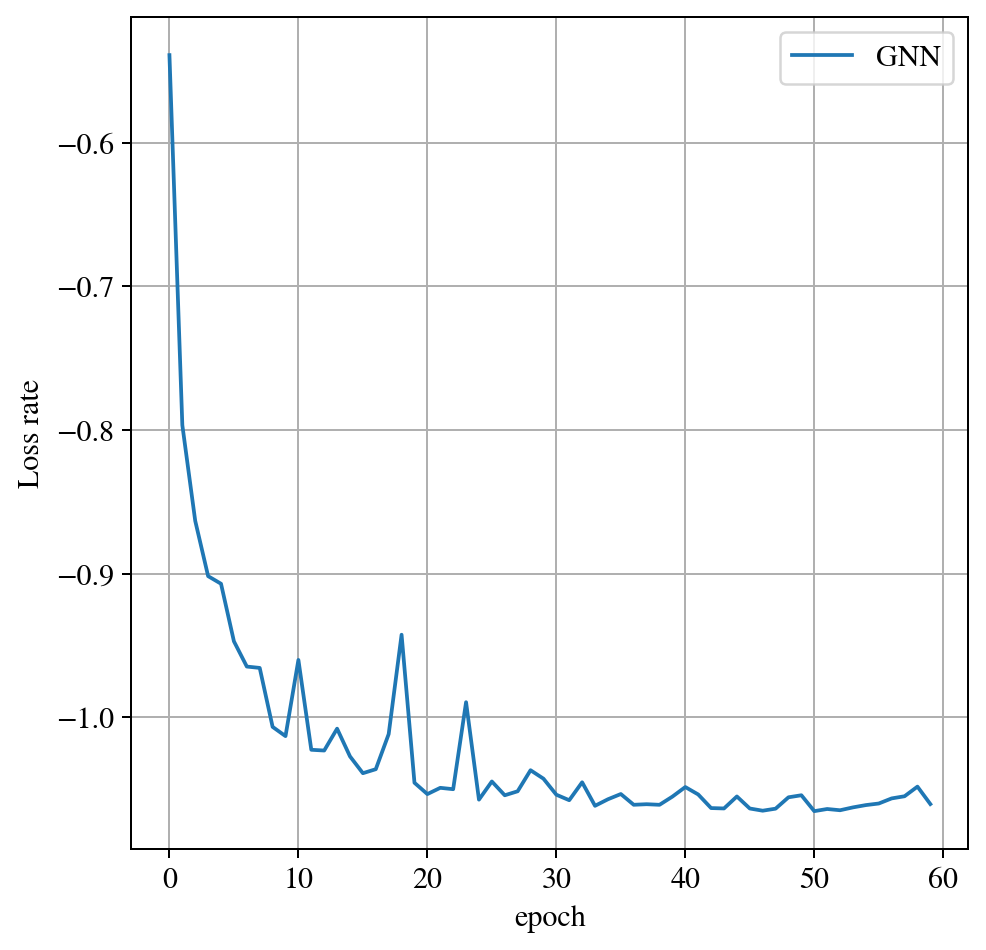

In [66]:
import matplotlib.pyplot as plt


plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(figsize=(6, 6), dpi=180)
x_values = list(range(60))

ax.plot(x_values, gnn_rates, label='GNN', linestyle='-')

ax.set_xlabel('epoch')
ax.set_ylabel('Loss rate')
ax.legend()
ax.grid()
plt.show()


In [30]:
gnn_rates = None
for (data, d_test, c_test) in test_loader:
    K = d_test.shape[-1]
    n = len(data['UE'].x)
    bs = len(data['UE'].x) // K
    #data = data.to(device)
    user_feats = data['AP'].x
    item_feats = data['UE'].x
    node_features = {'AP': user_feats, 'UE': item_feats}
    output = model(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs,-1)
    gnn_rates = rate_loss(output, d_test, c_test, True).flatten().detach().numpy()

In [32]:
test_model(test_loader, model)

-1.0362156629562378

# Quantum MLP

# HQGNN Amplitude Embedding

In [39]:
pip install pennylane

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\ADMIN\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [35]:
import pennylane as qml
from pennylane import numpy as np

n_qubits = 5
n_layers =  10
dev = qml.device('default.qubit', wires=n_qubits)


In [36]:
n_layers_circuit_X = 2
def circuit_X_entangling(weights, n_qubits):
    qml.CRX(weights[-1], wires=[n_qubits-1, 0])
    for i in range(n_qubits-1):
        qml.CRX(weights[i], wires=[i, (i+1)])

@qml.qnode(dev, interface='torch')
def circuit_X(inputs, layer_weights):
    qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits), normalize=True, pad_with=0.)
    for l in range(n_layers_circuit_X):
        circuit_X_entangling(layer_weights[l], n_qubits)
    return qml.probs(wires=range(n_qubits))
weight_shapes_circuit_X = { "layer_weights": (n_layers_circuit_X, n_qubits)}

In [37]:
n_layers_circuit_Z = 2
def circuit_Z_entangling(weights, n_qubits):
    qml.CRZ(weights[-1], wires=[n_qubits - 1, 0])
    for i in range(n_qubits - 1):
        qml.CRZ(weights[i], wires=[i, i + 1])

@qml.qnode(dev, interface='torch')
def circuit_Z(inputs, layer_weights):
    qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits), normalize=True, pad_with=0.)
    for l in range(n_layers_circuit_Z):
        circuit_Z_entangling(layer_weights[l], n_qubits)
    return qml.probs(wires=range(n_qubits))
weight_shapes_circuit_Z = { "layer_weights": (n_layers_circuit_Z, n_qubits)}

In [38]:
def MLP(channels, batch_norm=True):
    return Seq(*[
        Seq(Lin(channels[i - 1], channels[i]), ReLU(), BN(channels[i]))
        for i in range(1, len(channels))
    ])
class Q_layer(MessagePassing):
    def __init__(self,src_dim, dst_dim, edge_dim, **kwargs):
        super(Q_layer, self).__init__(aggr='mean')  # mean aggregation
        self.lin_res = qml.qnn.TorchLayer(circuit_Z, weight_shapes_circuit_Z)
        self.lin_qml = qml.qnn.TorchLayer(circuit_X, weight_shapes_circuit_X)
        self.in_linear = nn.Linear(src_dim + dst_dim + edge_dim, 2 ** n_qubits)
        self.bn = BN(2 ** n_qubits)

    def forward(self, x, edge_index, edge_attr):
        feat_src, feat_dst = x
        out = self.propagate(edge_index=edge_index, x=(feat_src, feat_dst), edge_attr=edge_attr)
        out = out + self.lin_res(feat_dst)
        return self.bn(out)

    def message(self, x_j, x_i, edge_attr):
        out = torch.cat([x_j, x_i, edge_attr], dim=1)
        out = self.in_linear(out)
        out = self.lin_qml(out)
        return out

    def update(self, aggr_out):
        return aggr_out

In [39]:
class RGCN_Hybrid_mid(nn.Module):
    def __init__(self):
        super(RGCN_Hybrid_mid, self).__init__()
        out_dim = 2**n_qubits
        edge_dim = 2

        self.conv1 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer(1, 1, edge_dim),
            ('AP', 'com', 'UE'): Q_layer(1, 1, edge_dim,)
        }, aggr='mean')

        self.conv2 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer(out_dim, out_dim, edge_dim),
            ('AP', 'com', 'UE'): Q_layer(out_dim, out_dim, edge_dim)
        }, aggr='mean')

        self.conv3 = HeteroConv({
             ('UE', 'com-by', 'AP'): Q_layer(out_dim, out_dim, edge_dim),
             ('AP', 'com', 'UE'): Q_layer(out_dim, out_dim, edge_dim)
         }, aggr='mean')

        self.mlp = MLP([32, 16])
        self.mlp = nn.Sequential(*[self.mlp, Seq(Lin(16, 1), Sigmoid())])
    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        out = self.conv1(x_dict, edge_index_dict, edge_attr_dict)
        out = self.conv2(out, edge_index_dict, edge_attr_dict)
        out = self.conv3(out, edge_index_dict, edge_attr_dict)
        out = self.mlp(out['UE'])
        return out

In [40]:
model_qml_amplitude = RGCN_Hybrid_mid().to()

optimizer_qml_amplitude = torch.optim.Adam(model_qml_amplitude.parameters(), lr=5e-4)
scheduler_qml_amplitude = torch.optim.lr_scheduler.StepLR(optimizer_qml_amplitude, step_size=10, gamma=0.9)

In [57]:
trainable_params = sum(p.numel() for p in model_qml_amplitude.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 9977


In [67]:
record_amplitude= []

for epoch in range(0, 100):

    with torch.no_grad():
        test_rate = test_model(test_loader, model_qml_amplitude)
        train_rate = test_model(train_loader, model_qml_amplitude)
        record_amplitude.append([train_rate, test_rate])
    if epoch % 1 == 0:
        print(f'Epoch {epoch:02d}, Train Rate: {train_rate:.4f}, Test Rate: {test_rate:.4f}')
    train_model(epoch, model_qml_amplitude, optimizer_qml_amplitude, train_loader)
    scheduler_qml_amplitude.step()

KeyboardInterrupt: 

In [62]:
amplitude_rate = [record_amplitude[i][0] for i in range(50)]

ValueError: x and y must have same first dimension, but have shapes (50,) and (60,)

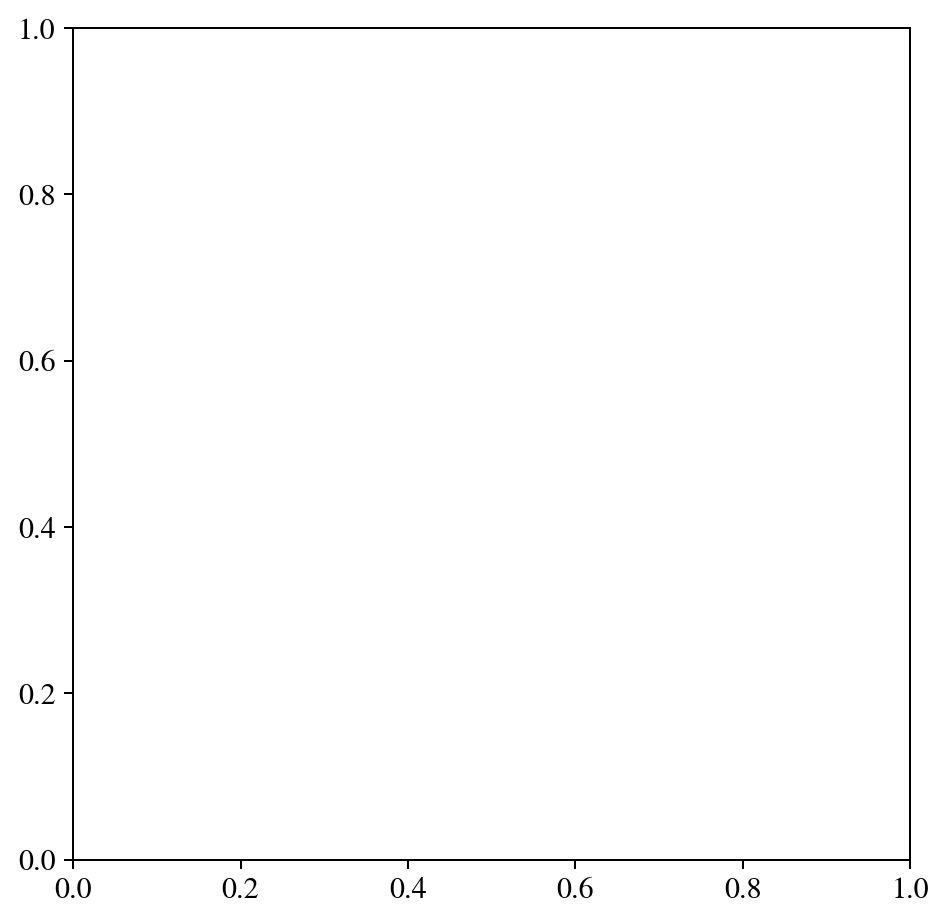

In [68]:
import matplotlib.pyplot as plt


plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(figsize=(6, 6), dpi=180)
x_values = list(range(50))

ax.plot(x_values, gnn_rates, label='GNN', linestyle='-')
ax.plot(x_values, amplitude_rate, label='QGNN', linestyle='-')

ax.set_xlabel('epoch')
ax.set_ylabel('Loss rate')
ax.legend()
ax.grid()
plt.show()


In [120]:
all_one_rates = None
gnn_q_rates = None
for (data, d_test, c_test) in test_loader:
    K = d_test.shape[-1]
    n = len(data['UE'].x)
    bs = len(data['UE'].x) // K
    user_feats = data['AP'].x
    item_feats = data['UE'].x
    node_features = {'AP': user_feats, 'UE': item_feats}
    output = model_qml_amplitude(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs,-1)
    full = torch.ones_like(output)
    all_one_rates = rate_loss(full, d_test, c_test, True).flatten().detach().numpy()
    gnn_q_rates = rate_loss(output, d_test, c_test, True).flatten().detach().numpy()
test_data = scipy.io.loadmat('cf_test_6_30.mat')
opt_rates = test_data['R_cf_opt_min']

In [121]:
min_rate, max_rate = 0, 2
y_axis = np.arange(0, 1.0, 1/202)
opt_rates.sort();gnn_rates.sort(); all_one_rates.sort();gnn_q_rates.sort()
gnn_q_rates = np.insert(gnn_q_rates, 0, min_rate); gnn_q_rates = np.insert(gnn_q_rates,201,max_rate)
gnn_rates = np.insert(gnn_rates, 0, min_rate); gnn_rates = np.insert(gnn_rates,201,max_rate)
all_one_rates = np.insert(all_one_rates, 0, min_rate); all_one_rates = np.insert(all_one_rates,201,max_rate)
opt_rates = np.insert(opt_rates, 0, min_rate); opt_rates = np.insert(opt_rates,201,max_rate)

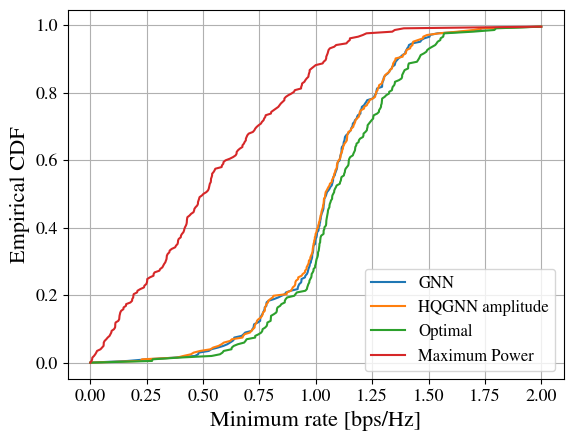

In [122]:
plt.plot(gnn_rates, y_axis, label = 'GNN')
#plt.plot(gnn_rates_qml_mid_angle, y_axis, label = 'HQGNN angle')
plt.plot(gnn_q_rates, y_axis, label = 'HQGNN amplitude')
plt.plot(opt_rates, y_axis, label = 'Optimal')
plt.plot(all_one_rates, y_axis, label = 'Maximum Power')
plt.xlabel('Minimum rate [bps/Hz]', {'fontsize':16})
plt.ylabel('Empirical CDF', {'fontsize':16})
plt.legend(fontsize = 12)
plt.grid()

In [123]:
print(f'QGNN in middle: {np.mean(gnn_q_rates)}')
print(f'GNN: {np.mean(gnn_rates)}')

QGNN in middle: 1.042984962463379
GNN: 1.0464998483657837


In [124]:
gnn_test_rates = None
gnn_test_rates_q = None
for (data, d_test, c_test) in test_loader:
    K = d_test.shape[-1]
    n = len(data['UE'].x)
    bs = len(data['UE'].x) // K
    user_feats = data['AP'].x
    item_feats = data['UE'].x
    node_features = {'AP': user_feats, 'UE': item_feats}
    output_qgnn = model_qml_amplitude(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs,-1)
    output_gnn = model(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)
    gnn_test_rates = rate_loss(output_gnn, d_test, c_test, True).flatten().detach().numpy()
    gnn_test_rates_q = rate_loss(output_qgnn, d_test, c_test, True).flatten().detach().numpy()

In [125]:
count = np.sum(gnn_test_rates_q > gnn_test_rates)
print(f'Number of samples where HQGNN outperforms GNN: {count}')

Number of samples where HQGNN outperforms GNN: 94


# Angle Embedding

In [46]:
import pennylane as qml
from pennylane import numpy as np

n_qubits = 5
dev = qml.device('default.qubit', wires=n_qubits)


In [47]:
n_layers_circuit_X2 = 1
def circuit_X2_entangling(weights, n_qubits):
    qml.CRX(weights[-1], wires=[n_qubits-1, 0])
    for i in range(n_qubits-1):
        qml.CRX(weights[i], wires=[i, (i+1)])

@qml.qnode(dev, interface='torch')
def circuit_X2(inputs, layer_weights):
    qml.AngleEmbedding(features=inputs, wires=range(n_qubits))
    for l in range(n_layers_circuit_X2):
        circuit_X2_entangling(layer_weights[l], n_qubits)
    return qml.probs(wires=range(n_qubits))
weight_shapes_circuit_X2 = { "layer_weights": (n_layers_circuit_X2, n_qubits)}

In [48]:
n_layers_circuit_Z2 = 1
def circuit_Z2_entangling(weights, n_qubits):
    qml.CRZ(weights[-1], wires=[n_qubits - 1, 0])
    for i in range(n_qubits - 1):
        qml.CRZ(weights[i], wires=[i, i + 1])

@qml.qnode(dev, interface='torch')
def circuit_Z2(inputs, layer_weights):
    qml.AngleEmbedding(features=inputs, wires=range(n_qubits))
    for l in range(n_layers_circuit_Z2):
        circuit_Z2_entangling(layer_weights[l], n_qubits)
    return qml.probs(wires=range(n_qubits))
weight_shapes_circuit_Z2 = { "layer_weights": (n_layers_circuit_Z2, n_qubits)}

In [49]:
def MLP(channels, batch_norm=True):
    return Seq(*[
        Seq(Lin(channels[i - 1], channels[i]), ReLU(), BN(channels[i]))
        for i in range(1, len(channels))
    ])
class Q_layer_angle(MessagePassing):
    def __init__(self,src_dim, dst_dim, edge_dim, out_dim, **kwargs):
        super(Q_layer_angle, self).__init__(aggr='mean')  
        self.lin_res = qml.qnn.TorchLayer(circuit_X2, weight_shapes_circuit_X2)
        self.lin_qml = qml.qnn.TorchLayer(circuit_Z2, weight_shapes_circuit_Z2)
        self.in_linear = nn.Linear(src_dim + dst_dim + edge_dim, out_dim)
        self.linear = nn.Linear(dst_dim, n_qubits)
        self.bn = BN(32)

    def forward(self, x, edge_index, edge_attr):
        feat_src, feat_dst = x
        out = self.propagate(edge_index=edge_index, x=(feat_src, feat_dst), edge_attr=edge_attr)
        out = out + self.lin_res(self.linear(feat_dst))
        return self.bn(out)

    def message(self, x_j, x_i, edge_attr):
        out = torch.cat([x_j, x_i, edge_attr], dim=1)
        out = self.in_linear(out)
        out = self.lin_qml(out)
        return out

    def update(self, aggr_out):
        return aggr_out

In [50]:
class RGCN_Hybrid_mid_angle(nn.Module):
    def __init__(self):
        super(RGCN_Hybrid_mid_angle, self).__init__()
        out_dim = n_qubits
        edge_dim = 2

        self.conv1 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer_angle(1, 1, edge_dim, out_dim),
            ('AP', 'com', 'UE'): Q_layer_angle(1, 1, edge_dim,out_dim)
        }, aggr='mean')

        self.conv2 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer_angle(32, 32, edge_dim, out_dim),
            ('AP', 'com', 'UE'): Q_layer_angle(32, 32, edge_dim, out_dim)
        }, aggr='mean')

        self.conv3 = HeteroConv({
             ('UE', 'com-by', 'AP'): Q_layer_angle(32, 32, edge_dim, out_dim),
             ('AP', 'com', 'UE'): Q_layer_angle(32, 32, edge_dim, out_dim)
         }, aggr='mean')

        self.mlp = MLP([32, 16])
        self.mlp = nn.Sequential(*[self.mlp, Seq(Lin(16, 1), Sigmoid())])
    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        out = self.conv1(x_dict, edge_index_dict, edge_attr_dict)
        out = self.conv2(out, edge_index_dict, edge_attr_dict)
        out = self.conv3(out, edge_index_dict, edge_attr_dict)
        out = self.mlp(out['UE'])
        return out

In [51]:
model_qml_mid_angle = RGCN_Hybrid_mid_angle().to()

optimizer_qml_mid_angle = torch.optim.Adam(model_qml_mid_angle.parameters(), lr=5e-4)
scheduler_qml_mid_angle = torch.optim.lr_scheduler.StepLR(optimizer_qml_mid_angle, step_size=10, gamma=0.9)

In [49]:
trainable_params = sum(p.numel() for p in model_qml_mid_angle.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 3091


In [ ]:
record_edge = []

for epoch in range(0, 30):

    with torch.no_grad():
        test_rate = test_model(test_loader, model_qml_mid_angle)
        train_rate = test_model(train_loader, model_qml_mid_angle)
        record_edge.append([train_rate, test_rate])
    if epoch % 1 == 0:
        print(f'Epoch {epoch:02d}, Train Rate: {train_rate:.4f}, Test Rate: {test_rate:.4f}')
    train_model(epoch, model_qml_mid_angle, optimizer_qml_mid_angle, train_loader)
    scheduler_qml_mid_angle.step()

In [74]:
for (data, d_test, c_test) in test_loader:
    K = d_test.shape[-1]
    n = len(data['UE'].x)
    bs = len(data['UE'].x) // K
    user_feats = data['AP'].x
    item_feats = data['UE'].x
    node_features = {'AP': user_feats, 'UE': item_feats}
    output_qgnn = model_qml_mid_angle(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs,-1)
    output_gnn = model(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)
    gnn_test_rates = rate_loss(output_gnn, d_test, c_test, True).flatten().detach().numpy()
    gnn_test_rates_q = rate_loss(output_qgnn, d_test, c_test, True).flatten().detach().numpy()

In [ ]:
import matplotlib.pyplot as plt
epsilon = 0.001 

positions_greater = np.where((gnn_test_rates_q - gnn_test_rates) > epsilon)[0]
positions_equal = np.where(np.abs(gnn_test_rates_q - gnn_test_rates) <= epsilon)[0]


count_greater = len(positions_greater)
count_equal = len(positions_equal)
count_not_greater = 200 - count_greater - count_equal


labels = ['HQGNN angle> GNN', 'HQGNN angle ≈ GNN', 'HQGNN angle < GNN']
sizes = [count_greater, count_equal, count_not_greater]
explode = (0.1, 0.1, 0)  


plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Tỷ lệ vị trí của HQGNN so với GNN với sai số 1e-3')
plt.show()


In [ ]:


epsilon = 0.001 

positions_greater = np.where((gnn_test_rates_q - gnn_test_rates) > epsilon)[0]
positions_equal = np.where(np.abs(gnn_test_rates_q - gnn_test_rates) <= epsilon)[0]


count_greater = len(positions_greater)
count_equal = len(positions_equal)
count_not_greater = 200 - count_greater - count_equal


labels = ['HQGNN angle> GNN', 'HQGNN angle ≈ GNN', 'HQGNN angle < GNN']
sizes = [count_greater, count_equal, count_not_greater]
explode = (0.1, 0.1, 0)  


plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Tỷ lệ vị trí của HQGNN so với GNN với sai số 1e-3')
plt.show()


In [131]:
gnn_rates_qml_mid_angle = None
all_one_rates = None
for (data, d_test, c_test) in test_loader:
    K = d_test.shape[-1]
    n = len(data['UE'].x)
    bs = len(data['UE'].x) // K
    #data = data.to(device)
    user_feats = data['AP'].x
    item_feats = data['UE'].x
    node_features = {'AP': user_feats, 'UE': item_feats}
    output = model_qml_mid_angle(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs,-1)
    gnn_rates_qml_mid_angle = rate_loss(output, d_test, c_test, True).flatten().detach().numpy()
    full = torch.ones_like(output)
    all_one_rates = rate_loss(full, d_test, c_test, True).flatten().detach().numpy()
#test_data = scipy.io.loadmat('cf_test_6_30.mat')
#opt_rates = test_data['R_cf_opt_min']

In [132]:
#min_rate, max_rate = 0, 2
#y_axis = np.arange(0, 1.0, 1/202)
all_one_rates.sort()
gnn_rates_qml_mid_angle.sort()#opt_rates.sort();gnn_rates.sort();gnn_rates_qml_mid_angle.sort(); all_one_rates.sort();gnn_q_rates.sort()
#gnn_q_rates = np.insert(gnn_q_rates, 0, min_rate); gnn_q_rates = np.insert(gnn_q_rates,201,max_rate)
gnn_rates_qml_mid_angle = np.insert(gnn_rates_qml_mid_angle, 0, min_rate); gnn_rates_qml_mid_angle = np.insert(gnn_rates_qml_mid_angle,201,max_rate)
#gnn_rates = np.insert(gnn_rates, 0, min_rate); gnn_rates = np.insert(gnn_rates,201,max_rate)
all_one_rates = np.insert(all_one_rates, 0, min_rate); all_one_rates = np.insert(all_one_rates,201,max_rate)
#opt_rates = np.insert(opt_rates, 0, min_rate); opt_rates = np.insert(opt_rates,201,max_rate)

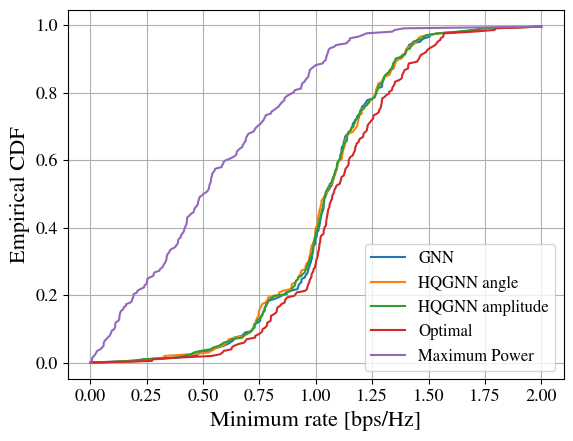

In [133]:
plt.plot(gnn_rates, y_axis, label = 'GNN')
plt.plot(gnn_rates_qml_mid_angle, y_axis, label = 'HQGNN angle')
plt.plot(gnn_q_rates, y_axis, label = 'HQGNN amplitude')
plt.plot(opt_rates, y_axis, label = 'Optimal')
plt.plot(all_one_rates, y_axis, label = 'Maximum Power')
plt.xlabel('Minimum rate [bps/Hz]', {'fontsize':16})
plt.ylabel('Empirical CDF', {'fontsize':16})
plt.legend(fontsize = 12)
plt.grid()

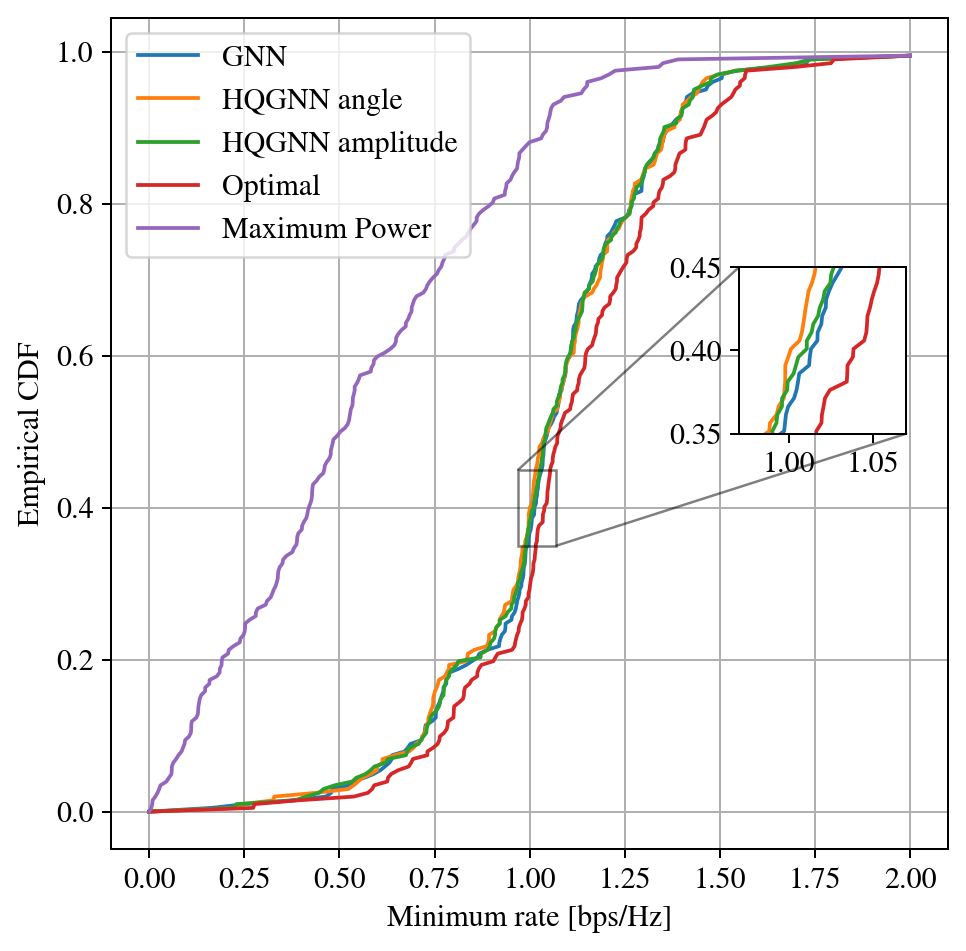

In [ ]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(6, 6), dpi=180)


ax.plot(gnn_rates, y_axis, label='GNN')
ax.plot(gnn_rates_qml_mid_angle, y_axis, label='HQGNN angle')
ax.plot(gnn_q_rates, y_axis, label='HQGNN amplitude')
ax.plot(opt_rates, y_axis, label='Optimal')
ax.plot(all_one_rates, y_axis, label='Maximum Power')


ax.set_xlabel('Minimum rate [bps/Hz]')
ax.set_ylabel('Empirical CDF')
ax.legend(loc='upper left' )
ax.grid()

# Define the zoomed area
x1, x2, y1, y2 = 0.97, 1.07, 0.35, 0.45

# Step 4: Create the inset axes with specific location and size
axins = ax.inset_axes([0.75, 0.5, 0.2, 0.2])  # Relative position and size of the inset

# Plot the same data on the inset
axins.plot(gnn_rates, y_axis, label='GNN')
axins.plot(gnn_rates_qml_mid_angle, y_axis, label='HQGNN angle')
axins.plot(gnn_q_rates, y_axis, label='HQGNN amplitude')
axins.plot(opt_rates, y_axis, label='Optimal')
axins.plot(all_one_rates, y_axis, label='Maximum Power')

# Set the zoom limits on the inset
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# Add zoom indication lines
ax.indicate_inset_zoom(axins, edgecolor="black")

# Display the plot
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def count_parameters(model):
    quantum_params = 0
    classical_params = 0
    for name, param in model.named_parameters():
        if 'lin_qml' in name or 'lin_res' in name:  # Phân loại các tham số thuộc về Quantum
            quantum_params += param.numel()
        else:  # Các tham số khác thuộc về Classical
            classical_params += param.numel()
    return quantum_params, classical_params
models = {
    "GNN": model,
    "HQGNN Amplitude": model_qml_amplitude,
    "HQGNN Angle": model_qml_mid_angle,
}

params_count = {
    name: count_parameters(model)
    for name, model in models.items()
}





avg_gnn_test_rates_angle = -test_model(test_loader, model_qml_mid_angle)
avg_gnn_test_rates_amplitude = -test_model(test_loader, model_qml_amplitude)
avg_gnn_test_rates = -test_model(test_loader, model)

test_data = scipy.io.loadmat('cf_test_6_30.mat')
opt_rates = np.sum(test_data['R_cf_opt_min'])/len(test_loader.dataset)

# Tính hiệu suất
performance_percentages = {
    "GNN": (avg_gnn_test_rates / opt_rates) * 100,
    "HQGNN Amplitude": (avg_gnn_test_rates_amplitude / opt_rates) * 100,
    "HQGNN Angle": (avg_gnn_test_rates_angle / opt_rates) * 100,
}

# Tạo DataFrame chứa kết quả
data = {
    "Model": ["GNN", "HQGNN Amplitude", "HQGNN Angle"],
    "Classical Parameters": [params_count["GNN"][1], params_count["HQGNN Amplitude"][1], params_count["HQGNN Angle"][1]],
    "Quantum Parameters": [params_count["GNN"][0], params_count["HQGNN Amplitude"][0], params_count["HQGNN Angle"][0]],
    "Performance (%)": [performance_percentages["GNN"], performance_percentages["HQGNN Amplitude"], performance_percentages["HQGNN Angle"]]
}
params_df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(8, 4))  # Kích thước hình ảnh
ax.axis('tight')  # Loại bỏ trục
ax.axis('off')  # Loại bỏ viền trục
table = ax.table(cellText=params_df.values, colLabels=params_df.columns, loc='center', cellLoc='center')

# Tùy chỉnh bảng
table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(params_df.columns))))

# Tăng khoảng cách giữa các hàng và cột
for (row, col), cell in table.get_celld().items():
    cell.set_linewidth(1.5)  # Độ dày đường kẻ
    cell.set_height(0.3)    # Tăng chiều cao hàng
    cell.set_width(0.25)    # Tăng chiều rộng cột

# Hiển thị bảng
plt.savefig("model_parameters_and_performance_table_full.png", dpi=300, bbox_inches='tight')
plt.show()


             Model  Classical Parameters  Quantum Parameters  Performance (%)
0              GNN                 14593                   0        92.517146
1  HQGNN Amplitude                  9857                 120        94.617035
2      HQGNN Angle                  3031                  60        94.792333


In [84]:
torch.save(model.state_dict(), 'model_parameters.pth')
torch.save(model_qml_amplitude.state_dict(), 'model_amplitude_parameters.pth')
torch.save(model_qml_mid_angle.state_dict(), 'model_angle_parameters.pth')

In [52]:
#model.load_state_dict(torch.load('model_parameters.pth'))
model_qml_amplitude.load_state_dict(torch.load('model_amplitude_parameters.pth'))
model_qml_mid_angle.load_state_dict(torch.load('model_angle_parameters.pth'))

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15368\3684890025.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_qml_amplitude.load_state_dict(torch.load('model_amplit

<All keys matched successfully>

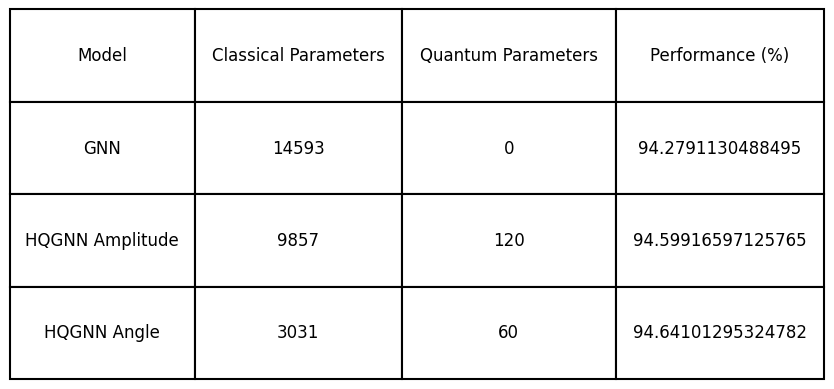

In [72]:
import pandas as pd
import matplotlib.pyplot as plt

def count_parameters(model):
    quantum_params = 0
    classical_params = 0
    for name, param in model.named_parameters():
        if 'lin_qml' in name or 'lin_res' in name:  # Phân loại các tham số thuộc về Quantum
            quantum_params += param.numel()
        else:  # Các tham số khác thuộc về Classical
            classical_params += param.numel()
    return quantum_params, classical_params
models = {
    "GNN": model,
    "HQGNN Amplitude": model_qml_amplitude,
    "HQGNN Angle": model_qml_mid_angle,
}

params_count = {
    name: count_parameters(model)
    for name, model in models.items()
}





avg_gnn_test_rates_angle = -test_model(test_loader, model_qml_mid_angle)
avg_gnn_test_rates_amplitude = -test_model(test_loader, model_qml_amplitude)
avg_gnn_test_rates = -test_model(test_loader, model)

test_data = scipy.io.loadmat('cf_test_6_30.mat')
opt_rates = np.sum(test_data['R_cf_opt_min'])/len(test_loader.dataset)

# Tính hiệu suất
performance_percentages = {
    "GNN": (avg_gnn_test_rates / opt_rates) * 100,
    "HQGNN Amplitude": (avg_gnn_test_rates_amplitude / opt_rates) * 100,
    "HQGNN Angle": (avg_gnn_test_rates_angle / opt_rates) * 100,
}

# Tạo DataFrame chứa kết quả
data = {
    "Model": ["GNN", "HQGNN Amplitude", "HQGNN Angle"],
    "Classical Parameters": [params_count["GNN"][1], params_count["HQGNN Amplitude"][1], params_count["HQGNN Angle"][1]],
    "Quantum Parameters": [params_count["GNN"][0], params_count["HQGNN Amplitude"][0], params_count["HQGNN Angle"][0]],
    "Performance (%)": [performance_percentages["GNN"], performance_percentages["HQGNN Amplitude"], performance_percentages["HQGNN Angle"]]
}
params_df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(8, 4))  # Kích thước hình ảnh
ax.axis('tight')  # Loại bỏ trục
ax.axis('off')  # Loại bỏ viền trục
table = ax.table(cellText=params_df.values, colLabels=params_df.columns, loc='center', cellLoc='center')

# Tùy chỉnh bảng
table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(params_df.columns))))

# Tăng khoảng cách giữa các hàng và cột
for (row, col), cell in table.get_celld().items():
    cell.set_linewidth(1.5)  # Độ dày đường kẻ
    cell.set_height(0.3)    # Tăng chiều cao hàng
    cell.set_width(0.25)    # Tăng chiều rộng cột

# Hiển thị bảng
plt.savefig("model_parameters_and_performance_table_full.png", dpi=300, bbox_inches='tight')
plt.show()


# Same Parameter

In [111]:
class RGCN(nn.Module):
    def __init__(self):
        super(RGCN, self).__init__()
        self.conv1 = HeteroConv({
            ('UE', 'com-by', 'AP'): EdgeConv(4, 1, 16),
            ('AP', 'com', 'UE'): EdgeConv(4, 1, 16)
        }, aggr='mean')

        self.conv2 = HeteroConv({
            ('UE', 'com-by', 'AP'): EdgeConv(34, 16, 21),
            ('AP', 'com', 'UE'): EdgeConv(34, 16, 21)
        }, aggr='mean')

        # self.conv3 = HeteroConv({
        #     ('UE', 'com-by', 'AP'): EdgeConv(66, 32, 32),
        #     ('AP', 'com', 'UE'): EdgeConv(66, 32, 32)
        # }, aggr='mean')

        self.mlp = MLP([21, 16])
        self.mlp = nn.Sequential(*[self.mlp, Seq(Lin(16, 1), Sigmoid())])
    def forward(self,x_dict, edge_index_dict, edge_attr_dict):
        out = self.conv1(x_dict, edge_index_dict, edge_attr_dict)
        out = self.conv2(out, edge_index_dict, edge_attr_dict)
        #out = self.conv3(out, edge_index_dict, edge_attr_dict)
        out = self.mlp(out['UE'])
        return out


In [181]:
model_gnn = RGCN()
optimizer = torch.optim.Adam(model_gnn.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)

In [146]:
trainable_params = sum(p.numel() for p in model_gnn.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 3105


HQGNN amplitude

In [116]:
n_qubits_amplitude = 4

In [119]:
n_layers_circuit_X = 1
def circuit_X_entangling(weights, n_qubits_amplitude):
    qml.CRX(weights[-1], wires=[n_qubits_amplitude-1, 0])
    for i in range(n_qubits_amplitude-1):
        qml.CRX(weights[i], wires=[i, (i+1)])

@qml.qnode(dev, interface='torch')
def circuit_X(inputs, layer_weights):
    qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits_amplitude), normalize=True, pad_with=0.)
    for l in range(n_layers_circuit_X):
        circuit_X_entangling(layer_weights[l], n_qubits_amplitude)
    return qml.probs(wires=range(n_qubits_amplitude))
weight_shapes_circuit_X = { "layer_weights": (n_layers_circuit_X, n_qubits_amplitude)}

In [138]:
n_layers_circuit_Z = 1
def circuit_Z_entangling(weights, n_qubits_amplitude):
    qml.CRZ(weights[-1], wires=[n_qubits_amplitude - 1, 0])
    for i in range(n_qubits_amplitude - 1):
        qml.CRZ(weights[i], wires=[i, i + 1])

@qml.qnode(dev, interface='torch')
def circuit_Z(inputs, layer_weights):
    qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits_amplitude), normalize=True, pad_with=0.)
    for l in range(n_layers_circuit_Z):
        circuit_Z_entangling(layer_weights[l], n_qubits_amplitude)
    return qml.probs(wires=range(n_qubits_amplitude))
weight_shapes_circuit_Z = { "layer_weights": (n_layers_circuit_Z, n_qubits_amplitude)}

In [139]:
class Q_layer(MessagePassing):
    def __init__(self,src_dim, dst_dim, edge_dim, **kwargs):
        super(Q_layer, self).__init__(aggr='mean')  # mean aggregation
        self.lin_res = qml.qnn.TorchLayer(circuit_Z, weight_shapes_circuit_Z)
        self.lin_qml = qml.qnn.TorchLayer(circuit_X, weight_shapes_circuit_X)
        self.in_linear = nn.Linear(src_dim + dst_dim + edge_dim, 2 ** n_qubits_amplitude)
        self.bn = BN(2 ** n_qubits_amplitude)

    def forward(self, x, edge_index, edge_attr):
        feat_src, feat_dst = x
        out = self.propagate(edge_index=edge_index, x=(feat_src, feat_dst), edge_attr=edge_attr)
        out = out + self.lin_res(feat_dst)
        return self.bn(out)

    def message(self, x_j, x_i, edge_attr):
        out = torch.cat([x_j, x_i, edge_attr], dim=1)
        out = self.in_linear(out)
        out = self.lin_qml(out)
        return out

    def update(self, aggr_out):
        return aggr_out

In [140]:
class RGCN_Hybrid_mid(nn.Module):
    def __init__(self):
        super(RGCN_Hybrid_mid, self).__init__()
        out_dim = 2**n_qubits_amplitude
        edge_dim = 2

        self.conv1 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer(1, 1, edge_dim),
            ('AP', 'com', 'UE'): Q_layer(1, 1, edge_dim,)
        }, aggr='mean')

        self.conv2 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer(out_dim, out_dim, edge_dim),
            ('AP', 'com', 'UE'): Q_layer(out_dim, out_dim, edge_dim)
        }, aggr='mean')

        self.conv3 = HeteroConv({
             ('UE', 'com-by', 'AP'): Q_layer(out_dim, out_dim, edge_dim),
             ('AP', 'com', 'UE'): Q_layer(out_dim, out_dim, edge_dim)
         }, aggr='mean')

        self.mlp = MLP([16, 20])
        self.mlp = nn.Sequential(*[self.mlp, Seq(Lin(20, 1), Sigmoid())])
    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        out = self.conv1(x_dict, edge_index_dict, edge_attr_dict)
        out = self.conv2(out, edge_index_dict, edge_attr_dict)
        #out = self.conv3(out, edge_index_dict, edge_attr_dict)
        out = self.mlp(out['UE'])
        return out

In [147]:
model_qml_amplitude = RGCN_Hybrid_mid().to()

optimizer_qml_amplitude = torch.optim.Adam(model_qml_amplitude.parameters(), lr=5e-4)
scheduler_qml_amplitude = torch.optim.lr_scheduler.StepLR(optimizer_qml_amplitude, step_size=10, gamma=0.9)

In [148]:
trainable_params = sum(p.numel() for p in model_qml_amplitude.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 3041


HQGNN angle

In [158]:
n_qubits = 5
 

In [58]:
n_layers_circuit_X2 = 1
def circuit_X2_entangling(weights, n_qubits):
    qml.CRX(weights[-1], wires=[n_qubits-1, 0])
    for i in range(n_qubits-1):
        qml.CRX(weights[i], wires=[i, (i+1)])

@qml.qnode(dev, interface='torch')
def circuit_X2(inputs, layer_weights):
    qml.AngleEmbedding(features=inputs, wires=range(n_qubits))
    for l in range(n_layers_circuit_X2):
        circuit_X2_entangling(layer_weights[l], n_qubits)
    return qml.probs(wires=range(n_qubits))
weight_shapes_circuit_X2 = { "layer_weights": (n_layers_circuit_X2, n_qubits)}

In [59]:
n_layers_circuit_Z2 = 1
def circuit_Z2_entangling(weights, n_qubits):
    qml.CRZ(weights[-1], wires=[n_qubits - 1, 0])
    for i in range(n_qubits - 1):
        qml.CRZ(weights[i], wires=[i, i + 1])

@qml.qnode(dev, interface='torch')
def circuit_Z2(inputs, layer_weights):
    qml.AngleEmbedding(features=inputs, wires=range(n_qubits))
    for l in range(n_layers_circuit_Z2):
        circuit_Z2_entangling(layer_weights[l], n_qubits)
    return qml.probs(wires=range(n_qubits))
weight_shapes_circuit_Z2 = { "layer_weights": (n_layers_circuit_Z2, n_qubits)}

In [60]:
def MLP(channels, batch_norm=True):
    return Seq(*[
        Seq(Lin(channels[i - 1], channels[i]), ReLU(), BN(channels[i]))
        for i in range(1, len(channels))
    ])
class Q_layer_angle(MessagePassing):
    def __init__(self,src_dim, dst_dim, edge_dim, out_dim, **kwargs):
        super(Q_layer_angle, self).__init__(aggr='mean')  
        self.lin_res = qml.qnn.TorchLayer(circuit_X2, weight_shapes_circuit_X2)
        self.lin_qml = qml.qnn.TorchLayer(circuit_Z2, weight_shapes_circuit_Z2)
        self.in_linear = nn.Linear(src_dim + dst_dim + edge_dim, out_dim)
        self.linear = nn.Linear(dst_dim, n_qubits)
        self.bn = BN(32)

    def forward(self, x, edge_index, edge_attr):
        feat_src, feat_dst = x
        out = self.propagate(edge_index=edge_index, x=(feat_src, feat_dst), edge_attr=edge_attr)
        out = out + self.lin_res(self.linear(feat_dst))
        return self.bn(out)

    def message(self, x_j, x_i, edge_attr):
        out = torch.cat([x_j, x_i, edge_attr], dim=1)
        out = self.in_linear(out)
        out = self.lin_qml(out)
        return out

    def update(self, aggr_out):
        return aggr_out

In [61]:
class RGCN_Hybrid_mid_angle(nn.Module):
    def __init__(self):
        super(RGCN_Hybrid_mid_angle, self).__init__()
        out_dim = n_qubits
        edge_dim = 2

        self.conv1 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer_angle(1, 1, edge_dim, out_dim),
            ('AP', 'com', 'UE'): Q_layer_angle(1, 1, edge_dim,out_dim)
        }, aggr='mean')

        self.conv2 = HeteroConv({
            ('UE', 'com-by', 'AP'): Q_layer_angle(32, 32, edge_dim, out_dim),
            ('AP', 'com', 'UE'): Q_layer_angle(32, 32, edge_dim, out_dim)
        }, aggr='mean')

        self.conv3 = HeteroConv({
             ('UE', 'com-by', 'AP'): Q_layer_angle(32, 32, edge_dim, out_dim),
             ('AP', 'com', 'UE'): Q_layer_angle(32, 32, edge_dim, out_dim)
         }, aggr='mean')

        self.mlp = MLP([32, 16])
        self.mlp = nn.Sequential(*[self.mlp, Seq(Lin(16, 1), Sigmoid())])
    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        out = self.conv1(x_dict, edge_index_dict, edge_attr_dict)
        out = self.conv2(out, edge_index_dict, edge_attr_dict)
        out = self.conv3(out, edge_index_dict, edge_attr_dict)
        out = self.mlp(out['UE'])
        return out

In [62]:
model_qml_angle = RGCN_Hybrid_mid_angle().to()

optimizer_qml_angle = torch.optim.Adam(model_qml_angle.parameters(), lr=5e-4)
scheduler_qml_angle = torch.optim.lr_scheduler.StepLR(optimizer_qml_angle, step_size=10, gamma=0.9)

In [168]:
trainable_params = sum(p.numel() for p in model_qml_angle.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 3091


Training

In [182]:
record = []

for epoch in range(0, 30):
    if epoch % 1 == 0:
        with torch.no_grad():
            test_rate = test_model(test_loader, model_gnn)
            train_rate = test_model(train_loader, model_gnn)
        print(f'Epoch {epoch:03d}, Train Rate: {train_rate:.4f}, Test Rate: {test_rate:.4f}')
        record.append([train_rate, test_rate])

    train_model(epoch, model_gnn, optimizer, train_loader )
    scheduler.step()


Epoch 000, Train Rate: -0.5361, Test Rate: -0.5360
Epoch 001, Train Rate: -0.6569, Test Rate: -0.6574
Epoch 002, Train Rate: -0.7393, Test Rate: -0.7416
Epoch 003, Train Rate: -0.7911, Test Rate: -0.7936
Epoch 004, Train Rate: -0.8362, Test Rate: -0.8369
Epoch 005, Train Rate: -0.8325, Test Rate: -0.8337
Epoch 006, Train Rate: -0.8879, Test Rate: -0.8746
Epoch 007, Train Rate: -0.8893, Test Rate: -0.8762
Epoch 008, Train Rate: -0.9124, Test Rate: -0.8966
Epoch 009, Train Rate: -0.8636, Test Rate: -0.8540
Epoch 010, Train Rate: -0.9491, Test Rate: -0.9267
Epoch 011, Train Rate: -0.8962, Test Rate: -0.8782
Epoch 012, Train Rate: -0.9677, Test Rate: -0.9397
Epoch 013, Train Rate: -0.9285, Test Rate: -0.9053
Epoch 014, Train Rate: -0.9634, Test Rate: -0.9360
Epoch 015, Train Rate: -0.9088, Test Rate: -0.8862
Epoch 016, Train Rate: -0.9483, Test Rate: -0.9253
Epoch 017, Train Rate: -0.8789, Test Rate: -0.8623
Epoch 018, Train Rate: -0.8593, Test Rate: -0.8443
Epoch 019, Train Rate: -0.6207,

In [153]:
record_edge = []

for epoch in range(0, 30):

    with torch.no_grad():
        test_rate = test_model(test_loader, model_qml_amplitude)
        train_rate = test_model(train_loader, model_qml_amplitude)
        record_edge.append([train_rate, test_rate])
    if epoch % 1 == 0:
        print(f'Epoch {epoch:02d}, Train Rate: {train_rate:.4f}, Test Rate: {test_rate:.4f}')
    train_model(epoch, model_qml_amplitude, optimizer_qml_amplitude, train_loader)
    scheduler_qml_amplitude.step()

Epoch 00, Train Rate: -0.5368, Test Rate: -0.5367
Epoch 01, Train Rate: -0.7692, Test Rate: -0.7497
Epoch 02, Train Rate: -0.8662, Test Rate: -0.8308
Epoch 03, Train Rate: -0.8737, Test Rate: -0.8243
Epoch 04, Train Rate: -1.0171, Test Rate: -0.9871
Epoch 05, Train Rate: -0.9509, Test Rate: -0.9173
Epoch 06, Train Rate: -0.9161, Test Rate: -0.8710
Epoch 07, Train Rate: -0.9165, Test Rate: -0.8810
Epoch 08, Train Rate: -0.9789, Test Rate: -0.9413
Epoch 09, Train Rate: -1.0227, Test Rate: -0.9854
Epoch 10, Train Rate: -0.9353, Test Rate: -0.9102
Epoch 11, Train Rate: -0.9459, Test Rate: -0.8953
Epoch 12, Train Rate: -0.9717, Test Rate: -0.9437
Epoch 13, Train Rate: -0.9621, Test Rate: -0.9356
Epoch 14, Train Rate: -1.0331, Test Rate: -1.0082
Epoch 15, Train Rate: -1.0353, Test Rate: -1.0143
Epoch 16, Train Rate: -1.0194, Test Rate: -0.9910
Epoch 17, Train Rate: -1.0136, Test Rate: -0.9881
Epoch 18, Train Rate: -0.9513, Test Rate: -0.8997
Epoch 19, Train Rate: -0.8999, Test Rate: -0.8611


In [173]:
record_edge = []

for epoch in range(0, 30):

    with torch.no_grad():
        test_rate = test_model(test_loader, model_qml_angle)
        train_rate = test_model(train_loader, model_qml_angle)
        record_edge.append([train_rate, test_rate])
    if epoch % 1 == 0:
        print(f'Epoch {epoch:02d}, Train Rate: {train_rate:.4f}, Test Rate: {test_rate:.4f}')
    train_model(epoch, model_qml_angle, optimizer_qml_angle, train_loader)
    scheduler_qml_angle.step()

Epoch 00, Train Rate: -0.5430, Test Rate: -0.5372
Epoch 01, Train Rate: -0.8569, Test Rate: -0.8398
Epoch 02, Train Rate: -0.9559, Test Rate: -0.9325
Epoch 03, Train Rate: -0.9881, Test Rate: -0.9637
Epoch 04, Train Rate: -1.0156, Test Rate: -0.9925
Epoch 05, Train Rate: -1.0202, Test Rate: -1.0024
Epoch 06, Train Rate: -1.0325, Test Rate: -1.0087
Epoch 07, Train Rate: -1.0307, Test Rate: -1.0118
Epoch 08, Train Rate: -1.0402, Test Rate: -1.0165
Epoch 09, Train Rate: -1.0425, Test Rate: -1.0189
Epoch 10, Train Rate: -1.0448, Test Rate: -1.0260
Epoch 11, Train Rate: -1.0447, Test Rate: -1.0221
Epoch 12, Train Rate: -1.0491, Test Rate: -1.0286
Epoch 13, Train Rate: -1.0485, Test Rate: -1.0268
Epoch 14, Train Rate: -1.0547, Test Rate: -1.0338
Epoch 15, Train Rate: -1.0523, Test Rate: -1.0327
Epoch 16, Train Rate: -1.0585, Test Rate: -1.0349
Epoch 17, Train Rate: -1.0608, Test Rate: -1.0379
Epoch 18, Train Rate: -1.0557, Test Rate: -1.0356
Epoch 19, Train Rate: -1.0515, Test Rate: -1.0271


KeyboardInterrupt: 

In [174]:
model_qml_angle.load_state_dict(torch.load('model_angle_parameters.pth'))

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16656\3179669080.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_qml_angle.load_state_dict(torch.load('model_angle_para

<All keys matched successfully>

In [183]:
import pandas as pd

# Hàm để đếm tham số của mô hình
def count_parameters(model):
    quantum_params = 0
    classical_params = 0
    for name, param in model.named_parameters():
        if 'lin_qml' in name or 'lin_res' in name:  # Phân loại các tham số thuộc về Quantum
            quantum_params += param.numel()
        else:  # Các tham số khác thuộc về Classical
            classical_params += param.numel()
    return quantum_params, classical_params

models = {
    "GNN": model_gnn,
    "HQGNN Amplitude": model_qml_amplitude,
    "HQGNN Angle": model_qml_angle,
}

params_count = {
    name: count_parameters(model)
    for name, model in models.items()
}

# Thực hiện các phép tính hiệu suất
for (data, d_test, c_test) in test_loader:
    K = d_test.shape[-1]
    n = len(data['UE'].x)
    bs = len(data['UE'].x) // K
    user_feats = data['AP'].x
    item_feats = data['UE'].x
    node_features = {'AP': user_feats, 'UE': item_feats}
    output_qgnn_angle = model_qml_angle(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)
    output_qgnn_amplitude = model_qml_amplitude(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)
    output_gnn = model_gnn(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)
    gnn_test_rates = rate_loss(output_gnn, d_test, c_test, True).flatten().detach().numpy()
    qgnn_test_rates_a = rate_loss(output_qgnn_angle, d_test, c_test, True).flatten().detach().numpy()
    qgnn_test_rates_q = rate_loss(output_qgnn_amplitude, d_test, c_test, True).flatten().detach().numpy()

avg_gnn_test_rates_angle = np.mean(qgnn_test_rates_a)
avg_gnn_test_rates_amplitude = np.mean(qgnn_test_rates_q)
avg_gnn_test_rates = np.mean(gnn_test_rates)
test_data = scipy.io.loadmat('cf_test_6_30.mat')
opt_rates = np.mean(test_data['R_cf_opt_min'])

# Hiệu suất
performance_percentages = {
    "GNN": (avg_gnn_test_rates / opt_rates) * 100,
    "HQGNN Amplitude": (avg_gnn_test_rates_amplitude / opt_rates) * 100,
    "HQGNN Angle": (avg_gnn_test_rates_angle / opt_rates) * 100,
}

# Tạo DataFrame
data = {
    "Model": ["GNN", "HQGNN Amplitude", "HQGNN Angle"],
    "Classical Parameters": [params_count["GNN"][1], params_count["HQGNN Amplitude"][1], params_count["HQGNN Angle"][1]],
    "Quantum Parameters": [params_count["GNN"][0], params_count["HQGNN Amplitude"][0], params_count["HQGNN Angle"][0]],
    
    "Performance (%)": [performance_percentages["GNN"], performance_percentages["HQGNN Amplitude"], performance_percentages["HQGNN Angle"]],
}

params_df = pd.DataFrame(data)

print(params_df)


             Model  Classical Parameters  Quantum Parameters  Performance (%)
0              GNN                  3105                   0        89.359717
1  HQGNN Amplitude                  2993                  48        92.645790
2      HQGNN Angle                  3031                  60        94.777762


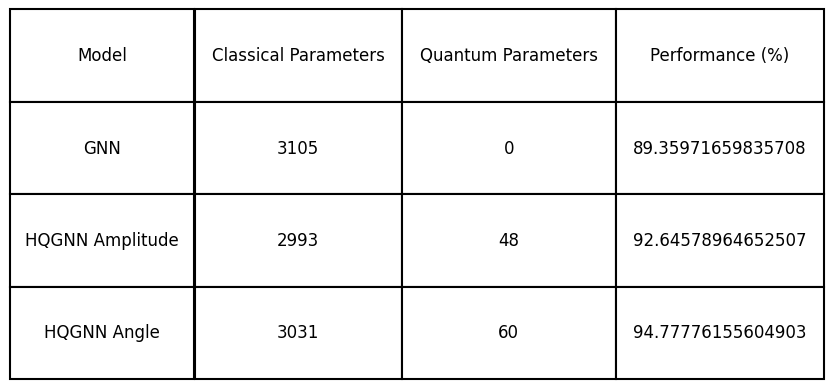

In [187]:
import pandas as pd
import matplotlib.pyplot as plt

# Hàm để đếm tham số của mô hình
def count_parameters(model):
    quantum_params = 0
    classical_params = 0
    for name, param in model.named_parameters():
        if 'lin_qml' in name or 'lin_res' in name:  # Phân loại các tham số thuộc về Quantum
            quantum_params += param.numel()
        else:  # Các tham số khác thuộc về Classical
            classical_params += param.numel()
    return quantum_params, classical_params

# Giả sử bạn đã định nghĩa `model_gnn`, `model_qml_amplitude`, và `model_qml_angle`
models = {
    "GNN": model_gnn,
    "HQGNN Amplitude": model_qml_amplitude,
    "HQGNN Angle": model_qml_angle,
}

params_count = {
    name: count_parameters(model)
    for name, model in models.items()
}


for (data, d_test, c_test) in test_loader:
    K = d_test.shape[-1]
    n = len(data['UE'].x)
    bs = len(data['UE'].x) // K
    user_feats = data['AP'].x
    item_feats = data['UE'].x
    node_features = {'AP': user_feats, 'UE': item_feats}
    
    # Output của các mô hình
    output_qgnn_angle = model_qml_angle(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)
    output_qgnn_amplitude = model_qml_amplitude(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)
    output_gnn = model_gnn(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)
    
    # Tính tỷ lệ hiệu suất
    gnn_test_rates = rate_loss(output_gnn, d_test, c_test, True).flatten().detach().numpy()
    qgnn_test_rates_a = rate_loss(output_qgnn_angle, d_test, c_test, True).flatten().detach().numpy()
    qgnn_test_rates_q = rate_loss(output_qgnn_amplitude, d_test, c_test, True).flatten().detach().numpy()
    
    avg_gnn_test_rates_angle = np.mean(qgnn_test_rates_a)
    avg_gnn_test_rates_amplitude = np.mean(qgnn_test_rates_q)
    avg_gnn_test_rates = np.mean(gnn_test_rates)
    test_data = scipy.io.loadmat('cf_test_6_30.mat')
    opt_rates = np.mean(test_data['R_cf_opt_min'])
    
performance_percentages = {
    "GNN": (avg_gnn_test_rates / opt_rates) * 100,
    "HQGNN Amplitude": (avg_gnn_test_rates_amplitude / opt_rates) * 100,
    "HQGNN Angle": (avg_gnn_test_rates_angle / opt_rates) * 100,
}


data = {
    "Model": ["GNN", "HQGNN Amplitude", "HQGNN Angle"],
    "Classical Parameters": [params_count["GNN"][1], params_count["HQGNN Amplitude"][1], params_count["HQGNN Angle"][1]],
    "Quantum Parameters": [params_count["GNN"][0], params_count["HQGNN Amplitude"][0], params_count["HQGNN Angle"][0]],
    "Performance (%)": [performance_percentages["GNN"], performance_percentages["HQGNN Amplitude"], performance_percentages["HQGNN Angle"]],
}
params_df = pd.DataFrame(data)

# Vẽ bảng từ DataFrame
fig, ax = plt.subplots(figsize=(8, 4))  # Kích thước hình ảnh
ax.axis('tight')  # Loại bỏ trục
ax.axis('off')  # Loại bỏ viền trục
table = ax.table(cellText=params_df.values, colLabels=params_df.columns, loc='center', cellLoc='center')

# Tùy chỉnh bảng
table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(params_df.columns))))

for (row, col), cell in table.get_celld().items():
    cell.set_linewidth(1.5)  # Độ dày đường kẻ
    cell.set_height(0.3)    # Tăng chiều cao hàng
    cell.set_width(0.25) 

# Hiển thị bảng
plt.savefig("model_parameters_table_from_code.png", dpi=300, bbox_inches='tight')
plt.show()
